In [1]:
from obs_models import *
from generate_data import *
from utils import *
%matplotlib inline
from pyro.distributions import TorchDistribution, Categorical, Empirical

In [2]:
from scipy.stats import multivariate_normal

In [3]:
N, D = 1000, 10
K = 4
random_data = []
for k in range(K):
    random_locs = np.random.randn(D)*10
    random_covariance_factor = np.random.rand(D,D)*np.random.randint(2,size=D*D).reshape(D,D)
    random_covariance = np.matmul(random_covariance_factor,random_covariance_factor.T)
    random_data.append(multivariate_normal(mean=random_locs,cov=random_covariance).rvs(size=N//K))

In [4]:
random_data = np.array(random_data).reshape(N,-1)

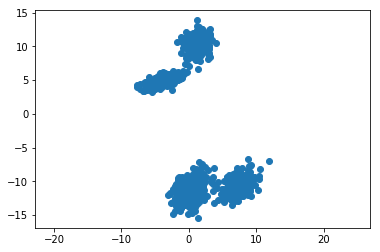

In [5]:
# plot two random dimensions against each other
pyplot.scatter(*random_data[:,np.random.choice(np.arange(D),size=2,replace=False)].T)
pyplot.axis('equal');

In [6]:
class PosteriorPredictive(TorchDistribution):
    '''Wrapper around TracePredictive'''
    has_rsample = False

    def prod(self, iterable):
        product = 1
        for i in iterable:
            product *= i
        return product
    
    def __init__(self, compositional_model, batch_shape=()):
        self.compositional_model = compositional_model
        if isinstance(batch_shape, int):
            self.n_samples = 1000
            batch_shape = (batch_shape,)
        elif batch_shape is None:
            self.n_samples = 1000
            batch_shape = ()
        elif isinstance(batch_shape, tuple) or isinstance(batch_shape, list):
            self.n_samples = max(self.prod(batch_shape), 1000)
            batch_shape = tuple(batch_shape)
        else:
            raise Exception('batch_shape must be integer or tuple')

        dummy_obs = torch.zeros((1,compositional_model.D))
        svi = SVI(compositional_model.model, compositional_model.guide, num_samples=self.n_samples, 
                  optim = compositional_model.optim, loss=compositional_model.elbo).run(dummy_obs)
        self.predictive = pyro.infer.TracePredictive(compositional_model.model, svi, num_samples=self.n_samples).run(dummy_obs)
        #for trace in self.predictive.exec_traces:
        #    print("Final trace"
        trace = self.predictive.exec_traces[0]
        #print([(k,v['value']) for k,v in trace.nodes.items() if 'value' in v])
        #print(trace.nodes)
        support = trace.nodes['obs']['fn'].support
        super(TorchDistribution, self).__init__(event_shape = (compositional_model.D,), 
                                                batch_shape = batch_shape, 
                                                validate_args = False)

    def __repr__(self):
        return 'Empirical PosteriorPredictive with {} samples'.format(self.n_samples)

    def __call__(self, *args, **kwargs):
        return self.sample(*args, **kwargs)

    def sample(self, sample_shape=None):
        print("Batch shape is {}".format(self.batch_shape))
        print("Sample shape is {}".format(sample_shape))
        print("Event shape is {}".format(self.event_shape))
        if sample_shape is None:
            sample_shape = torch.Size()
        if type(sample_shape) == int:
            sample_shape = (sample_shape,)
        assert self.prod(sample_shape + self.batch_shape) <= self.n_samples, \
            "Tried to sample more observations from PosteriorPredictive than it was initialized with"
        samples = torch.empty((self.prod(sample_shape + self.batch_shape),) + self.event_shape)
        for i,trace in enumerate(self.predictive.exec_traces):
            if i >= samples.shape[0]:
                break
            samples[i,:] = trace.nodes['obs']['value']
        return samples.reshape(sample_shape + self.batch_shape + self.event_shape)

    def log_prob(self, value): # log_sum_exp
        #    log p(x|X)
        #  = log int(p(x|theta)p(theta|X), dtheta)
        #  = log E_theta|X[p(x|theta)]
        #  = log sum(exp log p(x|theta))/N
        #  = logsumexp[log p(x|theta)] - log N
        """log_prob estimate from n_samples approximate posterior samples"""
        self.predictive_likelihood = torch.empty(value.shape[:-1] + (self.n_samples,))
        for i,trace in enumerate(self.predictive.exec_traces):
            self.predictive_likelihood[...,i] = trace.nodes['obs']['fn'].log_prob(value)
        return torch.logsumexp(self.predictive_likelihood, -1)-torch.log(torch.tensor(self.n_samples).float())
    
    def expand(self, target_batch_shape):
        print("target_batch_shape is {}".format(target_batch_shape))
        return PosteriorPredictive(self.compositional_model, target_batch_shape)

In [7]:
class CompositionalModel:
    """Base class for compositional models"""
    def __init__(self, X, parent = None):
        if not type(X) is torch.Tensor:
            X = torch.Tensor(X)
        self.parent = parent
        if not self.parent is None:
            assert issubclass(type(parent), CompositionalModel), "%r is not a CompositionalModel" % parent
            parent_guide_trace = pyro.poutine.trace(self.parent.guide).get_trace(torch.ones(1,D))
            # get parameters from parent and detach them
            # detach because pytorch only optimizes leaf tensors, meaning no operation tracked by the autograd engine created them
            self.parent_params = dict((name,pyro.param(name).detach()) for name in parent_guide_trace.param_nodes)
        else:
            self.parent_params = None
        self.X = X
        self.N, self.D = X.shape
        self.conditioned_model = None
        self.n_iter = 500
        # everything not passed on to thy children shall be lost to the void eternal
        pyro.clear_param_store()
        
    def __repr__(self):
        return ''
    
    def model(self, X):
        return X
    
    def conditionModel(self, X):
        if self.conditioned_model is None:
            self.conditioned_model = pyro.condition(self.model, data = {'obs': X})
        return self.conditioned_model(X)
    
    def guide(self, X):
        return None
    
    @pyro.ops.jit.trace
    def model_log_prob_fn(self):
        tr = pyro.poutine.trace(self.conditioned_model).get_trace(self.X)
        return tr.log_prob_sum()
        
    def per_param_callable(self, module_name, param_name):
        return {"lr": 0.01, 'betas': [0.9, 0.99]}

    def initialize(self, seed):
        # evaluate loss on a randomly initialized parameter-set 
        pyro.set_rng_seed(seed)
        loss = self.svi.loss(self.conditioned_model, self.guide, self.X)
        return loss
        
    def inference(self, n_iter = None, track_params = False):
        if n_iter is None:
            n_iter = self.n_iter
        self.conditionModel(self.X)
        self.optim = pyro.optim.Adam(self.per_param_callable)
        self.elbo = Trace_ELBO()
        self.svi = SVI(self.conditioned_model, self.guide, self.optim, loss=self.elbo)

        loss, seed = min((self.initialize(seed), seed) for seed in range(100))
        # Register hooks to monitor gradient norms.
        self.losses = []
        self.gradient_norms = defaultdict(list)
        if track_params:
            self.param_history = dict({k:v.unsqueeze(0) for k,v in pyro.get_param_store().items()})
        
        # register gradient hooks for monitoring
        for name, value in pyro.get_param_store().named_parameters():
            value.register_hook(lambda g, name=name: self.gradient_norms[name].append(g.norm().item()))

        # optimize
        for i in range(n_iter):
            loss = self.svi.step(self.X)
            self.losses.append(loss)
            if track_params:
                # warning: this builds the param_history dict from scratch in every iteration
                self.param_history = {k:torch.cat([self.param_history[k],v.unsqueeze(0)],dim=0) for k,v in pyro.get_param_store().items()}
            print('.' if i % 100 else '\n', end='')
        
        self.params = pyro.get_param_store().get_state()
    
    def plot_learning_curve(self):
        pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
        pyplot.plot(self.losses)
        pyplot.xlabel('iters')
        pyplot.ylabel('loss')
        pyplot.yscale('log')
        pyplot.title('Convergence of SVI');
        
    def plot_gradient_norms(self):
        pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
        for name, grad_norms in self.gradient_norms.items():
            pyplot.plot(grad_norms, label=name)
        pyplot.xlabel('iters')
        pyplot.ylabel('gradient norm')
        pyplot.yscale('log')
        pyplot.legend(loc='best')
        pyplot.title('Gradient norms during SVI');
        
#    def posterior_predictive(self, n_samples = None):
#        if n_samples is None:
#            n_samples = self.N
#        dummy_obs = torch.zeros((1,D))
#        guide_trace = pyro.poutine.trace(self.guide).get_trace(dummy_obs)
#        plate_stack = [node['cond_indep_stack'] for node in guide_trace.nodes.values() if 'cond_indep_stack' in node]
#        plate_stack_depth = max(map(len, plate_stack))
#        # dim of n_samples plate only works if there aren't any plates in the model outside nested plates
#        with pyro.plate('n_samples', n_samples, dim=-(plate_stack_depth+2)):
#            # sample latent variables from guide
#            guide_trace = pyro.poutine.trace(self.guide).get_trace(dummy_obs)
#            # sample observations given latent variables
#            #blockreplay = pyro.poutine.block(fn = pyro.poutine.replay(self.model, guide_trace),expose=['obs'])
#            replay = pyro.poutine.replay(self.model, guide_trace)
#            posterior_predictive = replay(dummy_obs)
#        return posterior_predictive
    
#    def posterior_predictive(self, n_samples = None):
#        # p(x|X)
#        pyro.get_param_store().set_state(self.params)
#        if n_samples is None:
#            n_samples = self.N
#        dummy_obs = torch.zeros((1,D))
#        svi2 = SVI(self.model, self.guide, num_samples=n_samples, optim = self.optim, loss=self.elbo).run(dummy_obs)
#        self.predictive = pyro.infer.TracePredictive(self.model, svi2, num_samples=n_samples).run(dummy_obs)
#        ppc = torch.empty((n_samples, D))
#        for i,trace in enumerate(self.predictive.exec_traces):
#            ppc[i,:] = trace.nodes['obs']['value']
#        return ppc
#    
#    def predictive_likelihood(self, data):
#        print(type(self))
#        # calculating log_prob for posterior predictive p(x|X) = int p(x|theta)p(theta|X) dtheta
#        self.predictive_likelihood = 0
#        for i,trace in enumerate(self.predictive.exec_traces):
#            self.predictive_likelihood += trace.nodes['obs']['fn'].log_prob(data)
#        return log_prob/(i+1)
    
    def posterior_predictive(self, batch_shape = None):
        """Returns a Distribution object, which has sample and log_prob methods"""
        return PosteriorPredictive(self, batch_shape)
    
    def plot_posterior_predictive(self, n_samples = None):
        # plot two random dimensions against each other
        if n_samples is None:
            n_samples = self.N
        random_idx = np.random.choice(np.arange(D),size=2,replace=False)
        ppc = np.squeeze(np.array(self.posterior_predictive()(n_samples).detach().numpy()))
        data = self.X.detach().numpy()
        pyplot.scatter(*data[:,random_idx].T, alpha=.2)
        #pyplot.scatter(*fa.predictive_check()[:,random_idx].T, alpha=.1)
        pyplot.scatter(*ppc[:,random_idx].T, alpha=.1)
        pyplot.axis('equal');

In [8]:
class IndependentGaussian(CompositionalModel):
    """Gaussian observations with no latent structure"""
    def __init__(self, X, parent = None):
        super(IndependentGaussian, self).__init__(X, parent = None)
        self.n_iter = 500 # no finetuning necessary
        
    def __repr__(self):
        return 'G'
    
    def model(self, X):
        N, D = X.shape # not using self.N and self.D, since model can be used with otherwise shaped tensors
        with pyro.plate('D_{}'.format(self), D):
            loc = pyro.sample('loc_{}'.format(self), dst.Normal(0.,10.))
            scale = pyro.sample('scale_{}'.format(self), dst.LogNormal(0.,4.))
            with pyro.plate('N_{}'.format(self), N):
                X = pyro.sample('obs', dst.Normal(loc,scale))
        return X
    
    def guide(self, X):
        N, D = X.shape
        with pyro.plate('D_{}'.format(self), D):
            # parameters
            loc_loc = pyro.param('loc_loc_{}'.format(self), torch.zeros(D))
            loc_scale = pyro.param('loc_scale_{}'.format(self), torch.ones(D), constraint=constraints.positive)
            scale_loc = pyro.param('scale_loc_{}'.format(self), torch.zeros(D))
            scale_scale = pyro.param('scale_scale_{}'.format(self), torch.ones(D), constraint=constraints.positive)
            # latent variables
            loc = pyro.sample('loc_{}'.format(self), dst.Normal(loc_loc,loc_scale))
            scale = pyro.sample('scale_{}'.format(self), dst.LogNormal(scale_loc,scale_scale))
            return loc, scale

    def initialize(self, seed):
        # evaluate loss on a randomly initialized parameter-set 
        pyro.set_rng_seed(seed)
        pyro.clear_param_store()
        pyro.param('loc_loc_{}'.format(self), self.X.mean(0))
        pyro.param('scale_loc_{}'.format(self), torch.log(self.X.std(0)), constraint=constraints.positive)
        loss = self.svi.loss(self.conditioned_model, self.guide, self.X)
        return loss

In [9]:
class LowRankGaussian(CompositionalModel):
    """Gaussian obervations with low rank covariance matrix"""
    def __init__(self, X, parent = None):
        super(LowRankGaussian, self).__init__(X, parent)
        if parent is None:
            self.n_iter = 1200
        else:
            self.n_iter = 600
        
    def __repr__(self):
        return 'GG + G' # G -> GG + G, GG + G -> GG + G
    
    def model(self, X):
        N, D = X.shape # not using self.N and self.D, since model can be used with otherwise shaped tensors
        if type(self.parent) is IndependentGaussian:
            self.K = 1
            cov_factor_loc = torch.zeros(1,D)
            cov_factor_scale = torch.ones(1,D)
        elif type(self.parent) is LowRankGaussian:
            self.K = self.parent.K + 1
            cov_factor_loc = torch.cat([self.parent_params['cov_factor_loc_{}'.format(self.parent)], torch.zeros(1,D)])
            cov_factor_scale = torch.cat([self.parent_params['cov_factor_scale_{}'.format(self.parent)], torch.ones(1,D)])
        else: 
            # If not inheriting from either IndependentGaussian or LowRankGaussian, continuing with full covariance
            self.K = D
            self.parent_params = \
            dict({'loc_loc_{}'.format(self.parent) : torch.zeros(D),\
                  'loc_scale_{}'.format(self.parent) : torch.ones(D),\
                  'scale_loc_{}'.format(self.parent) : torch.zeros(D),\
                  'scale_scale_{}'.format(self.parent) : torch.ones(D),\
                 })
            cov_factor_loc = torch.zeros(self.K,D)
            cov_factor_scale = torch.ones(self.K,D)
        with pyro.plate('D_{}'.format(self), D, dim=-1):
            # mean prior is inherited from parent
            locloc = self.parent_params['loc_loc_{}'.format(self.parent)]
            locscale = self.parent_params['loc_scale_{}'.format(self.parent)]
            # noise variance prior is inherited depending on type of parent
            scaleloc = self.parent_params['scale_loc_{}'.format(self.parent)]
            scalescale = self.parent_params['scale_scale_{}'.format(self.parent)]
            loc = pyro.sample('loc_{}'.format(self), dst.Normal(locloc, locscale))
            # covariance distributions are inherited from parent if it's a LowRankGaussian
            cov_diag = pyro.sample('scale_{}'.format(self), dst.LogNormal(scaleloc, scalescale))
            with pyro.plate('K_{}'.format(self), self.K, dim=-2):
                # if parent has covariance parameters, use them as priors, otherwise set weak priors (or use average of the rest?)
                cov_factor = pyro.sample('cov_factor_{}'.format(self), dst.Normal(cov_factor_loc,cov_factor_scale))
            cov_factor = cov_factor.transpose(0,1)
        with pyro.plate('N_{}'.format(self), N):
            X = pyro.sample('obs', dst.LowRankMultivariateNormal(loc, cov_factor=cov_factor, cov_diag=cov_diag))
        return X
    
    def guide(self, X):
        N, D = X.shape
        # assuming model has been run first
        if type(self.parent) is IndependentGaussian:
            self.K = 1
            cov_factor_loc = torch.zeros(1,D)
            cov_factor_scale = torch.ones(1,D)
        elif type(self.parent) is LowRankGaussian:
            self.K = self.parent.K + 1
            cov_factor_loc = torch.cat([self.parent_params['cov_factor_loc_{}'.format(self.parent)], torch.zeros(1,D)])
            cov_factor_scale = torch.cat([self.parent_params['cov_factor_scale_{}'.format(self.parent)], torch.ones(1,D)])
        else: 
            # If not inheriting from either IndependentGaussian or LowRankGaussian, continuing with full covariance
            self.K = D
            self.parent_params = \
            dict({'loc_loc_{}'.format(self.parent) : torch.zeros(D),\
                  'loc_scale_{}'.format(self.parent) : torch.ones(D),\
                  'scale_loc_{}'.format(self.parent) : torch.zeros(D),\
                  'scale_scale_{}'.format(self.parent) : torch.ones(D),\
                 })
            cov_factor_loc = torch.zeros(self.K,D)
            cov_factor_scale = torch.ones(self.K,D)
        with pyro.plate('D_{}'.format(self), D, dim=-1):
            # get initial parameter values from parent
            locloc = self.parent_params['loc_loc_{}'.format(self.parent)]
            locscale = self.parent_params['loc_scale_{}'.format(self.parent)]
            scaleloc = self.parent_params['scale_loc_{}'.format(self.parent)]
            scalescale = self.parent_params['scale_scale_{}'.format(self.parent)]
            # define parameters
            loc_loc = pyro.param('loc_loc_{}'.format(self), locloc)
            loc_scale = pyro.param('loc_scale_{}'.format(self), locscale, constraint=constraints.positive)
            cov_diag_loc = pyro.param('scale_loc_{}'.format(self), scaleloc)
            cov_diag_scale = pyro.param('scale_scale_{}'.format(self), scalescale, constraint=constraints.positive)
            # sample variables
            loc = pyro.sample('loc_{}'.format(self), dst.Normal(loc_loc,loc_scale))
            with pyro.plate('K_{}'.format(self), self.K, dim=-2):
                cov_factor_loc = pyro.param('cov_factor_loc_{}'.format(self), cov_factor_loc)
                cov_factor_scale = pyro.param('cov_factor_scale_{}'.format(self), cov_factor_scale, constraint=constraints.positive)
                cov_factor = pyro.sample('cov_factor_{}'.format(self), dst.Normal(cov_factor_loc, cov_factor_scale))
            cov_factor = cov_factor.transpose(0,1)
            cov_diag = pyro.sample('scale_{}'.format(self), dst.LogNormal(cov_diag_loc, cov_diag_scale))
        return loc, cov_factor, cov_diag

    def initialize(self, seed):
        # evaluate loss on a randomly initialized parameter-set 
        pyro.set_rng_seed(seed)
        loss = self.svi.loss(self.conditioned_model, self.guide, self.X)
        return loss

In [10]:
# to make a G(MG + G) + G model, i.e. projected Gaussian mixture (with IFA as special case where the mixture is factorized)
# first infer local source variables for GG + G
# then apply any rule to the source variables, e.g. MG + G

In [11]:
#[node for trace in fa.posterior_predictive(2).predictive.exec_traces for node in trace.nodes.values()]

In [12]:
ig = IndependentGaussian(random_data)

In [13]:
ig.inference(track_params = True)


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

In [14]:
pp = ig.posterior_predictive()

In [15]:
pp(12).shape

Batch shape is ()
Sample shape is 12
Event shape is (10,)


torch.Size([12, 10])

Batch shape is ()
Sample shape is 1000
Event shape is (10,)


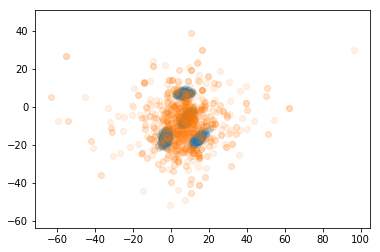

In [16]:
ig.plot_posterior_predictive()

In [17]:
fa = LowRankGaussian(random_data, parent=ig)

In [18]:
fa.inference()


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

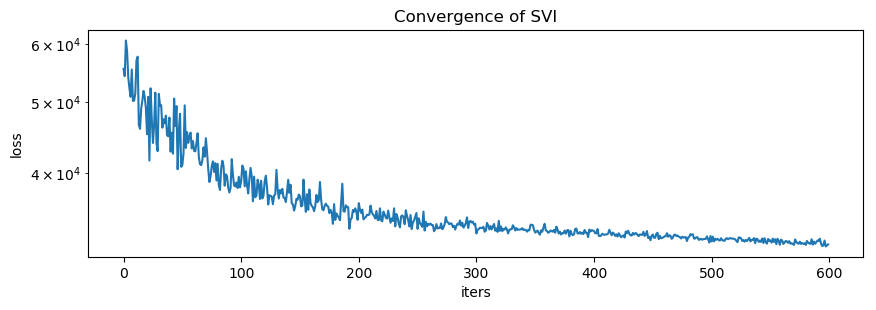

In [19]:
fa.plot_learning_curve()

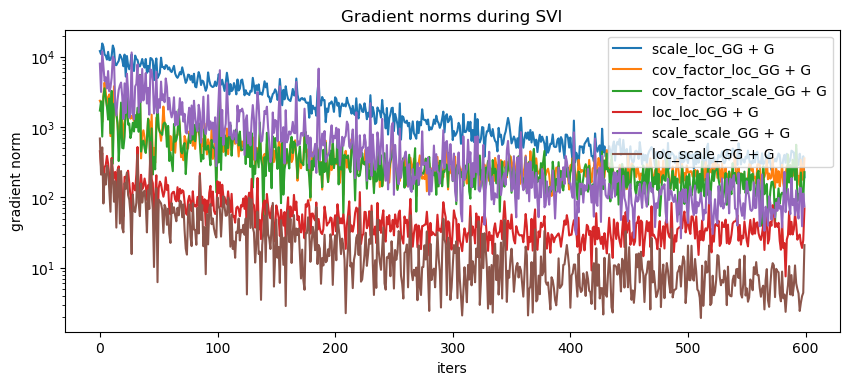

In [20]:
fa.plot_gradient_norms()

Batch shape is ()
Sample shape is 1000
Event shape is (10,)


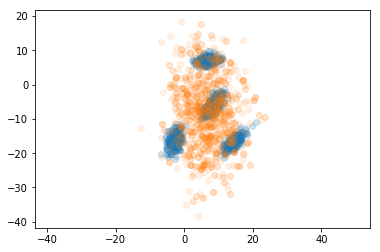

In [21]:
fa.plot_posterior_predictive(1000)

In [22]:
#fa2 = LowRankGaussian(random_data, parent=fa)
#
#fa2.parent_params
#
#fa2.inference()
#
#fa3 = LowRankGaussian(random_data, parent=fa2)
#
#fa3.inference()
#
#fa4 = LowRankGaussian(random_data, parent=fa3)
#
#fa4.inference(track_params=True)
#
#fa4.plot_posterior_predictive()

In [23]:
fa2 = LowRankGaussian(random_data, parent=fa)
fa2.inference()


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

Batch shape is ()
Sample shape is 1000
Event shape is (10,)


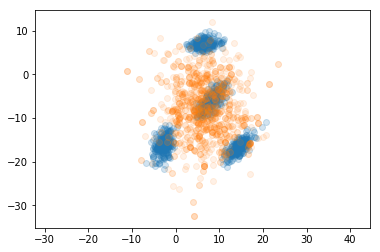

In [24]:
fa2.plot_posterior_predictive()

In [25]:
locs = pyro.sample('locs', fa2.posterior_predictive(2).to_event(1))

Batch shape is (2,)
Sample shape is torch.Size([])
Event shape is (10,)


In [26]:
locs.shape

torch.Size([2, 10])

In [35]:
locs

tensor([[-8.6460,  3.1362, -6.6038,  7.6278, 13.1215, -7.7688, -3.6523,  2.4473,
          5.3296, 12.2600],
        [-7.7002, -2.9142, -3.9704,  4.1410, -3.0848, -4.3962,  1.3338, -1.5730,
         10.0105, -5.8230]], grad_fn=<AsStridedBackward>)

In [80]:
tmp = fa2.posterior_predictive(2).to_event(1)

In [81]:
tmp.event_dim

2

In [82]:
tmp.event_shape

(2, 10)

In [30]:
foo = fa2.posterior_predictive(2)

In [31]:
foo.event_dim

1

In [89]:
class GaussianMixtureSharedDiagCovariance(CompositionalModel):
    """Observations from a mixture of Gaussian with shared diagonal covariance matrix"""
    def __init__(self, X, parent = None):
        super(GaussianMixtureSharedDiagCovariance, self).__init__(X, parent)
        self.n_iter = 1000
            
    def __repr__(self):
        return 'MG + G' 
        # G -> MG + G
        # GG + G -> MG + G
        # MG +G -> MG + G
    
    def model(self, X):
        N, D = X.shape
        if type(self.parent) is LowRankGaussian:
            self.K = 2
            # find analytical expression for posterior predictive and use as mean distribution
            # or sample directly from posterior predictive
        elif type(self.parent) is GaussianMixtureSharedDiagCovariance:
            self.K = self.parent.K + 1
        else:
            self.K = D

        # sample locs from parent
        #with pyro.plate('K', self.K):
            #locs = pyro.sample('locs', parent.posterior_predictive, 1)
        #locs = pyro.sample('locs', self.parent.posterior_predictive, self.K)
        #with pyro.plate('K', self.K, dim=-3): # dim is hardcoded, should be one more than max_plate_nest of parent
            # too few dims lead to shape mismatch, too many force downstream functions into batch_mode
            # must squeeeeeze
        #    locs = pyro.sample('locs', self.parent.posterior_predictive(self.K))
        #locs = locs.squeeze()
        
        locs = pyro.sample('locs', self.parent.posterior_predictive(self.K).to_event(1)) #  posterior_predictive has event_dim 1
        #locs = pyro.sample('locs', dst.Normal(torch.ones(2,10),1).to_event(1)) #  posterior_predictive has event_dim 1
        print("Model locs shape is {}".format(locs.shape))
        with pyro.plate('D', D):
            coord_scale = pyro.sample('coord_scale', dst.LogNormal(loc=torch.zeros((D)),scale=torch.ones(D)))
        component_logits = pyro.sample('component_logits', dst.Dirichlet(concentration=torch.ones(self.K)))
        with pyro.plate('N', N):
            X = pyro.sample('obs', dst.MixtureOfDiagNormalsSharedCovariance(locs = locs, coord_scale = coord_scale, component_logits = component_logits))

    def guide(self, X):    
        N, D = X.shape
        if type(self.parent) is LowRankGaussian:
            self.K = 2
        elif type(self.parent) is GaussianMixtureSharedDiagCovariance:
            self.K = self.parent.K + 1
        else:
            K = D
            
        #with pyro.plate('K', self.K, dim=-2):
        locs_loc = pyro.param('locs_loc', self.parent_params['loc_loc_{}'.format(self.parent)].repeat(self.K,1))
        locs_scale = pyro.param('locs_scale', self.parent_params['loc_scale_{}'.format(self.parent)].repeat(self.K,1), constraint=constraints.positive)
        locs = pyro.sample('locs', dst.Normal(locs_loc, locs_scale).to_event(2))
        print("Guide locs shape is {}".format(locs.shape))
        with pyro.plate('D', D):
            coord_scale_loc = pyro.param('coord_scale_loc', self.parent_params['scale_loc_{}'.format(self.parent)])
            coord_scale_scale = pyro.param('coord_scale_scale', self.parent_params['scale_scale_{}'.format(self.parent)], constraint=constraints.positive)
            coord_scale = pyro.sample('coord_scale', dst.LogNormal(loc=coord_scale_loc,scale=coord_scale_scale))
        #print(coord_scale.shape)
        #print(coord_scale.dim())
        #print(D)
        component_logits_concentration = pyro.param('component_logits_concentration', torch.ones(self.K), constraint=constraints.positive)
        component_logits = pyro.sample('component_logits', dst.Dirichlet(concentration=component_logits_concentration))
        return locs, coord_scale, component_logits
        
    def initialize(self, seed):
        # evaluate loss on a randomly initialized parameter-set 
        pyro.set_rng_seed(seed)
        loss = self.svi.loss(self.conditioned_model, self.guide, self.X)
        return loss

In [90]:
#mg = GaussianMixtureSharedDiagCovariance(random_data, parent=fa4)
mg = GaussianMixtureSharedDiagCovariance(random_data, parent=fa2)
#mg = GaussianMixtureSharedDiagCovariance(random_data, parent=fa) #this fails because fa2 has redefined parameters, leading to shape mismatch

In [91]:
mg.inference()

Batch shape is (2,)
Sample shape is torch.Size([])
Event shape is (10,)
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide lo

Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Si

.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.S

Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Si

.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.S

Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Si

.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.S

Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Si

.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.S

Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Si

.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
.Guide locs shape is torch.S

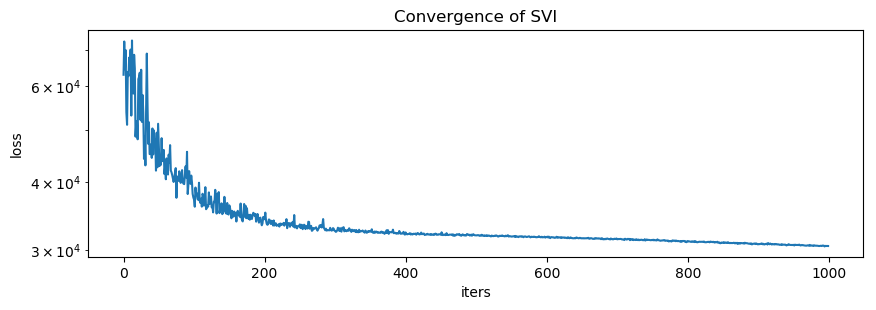

In [92]:
mg.plot_learning_curve()

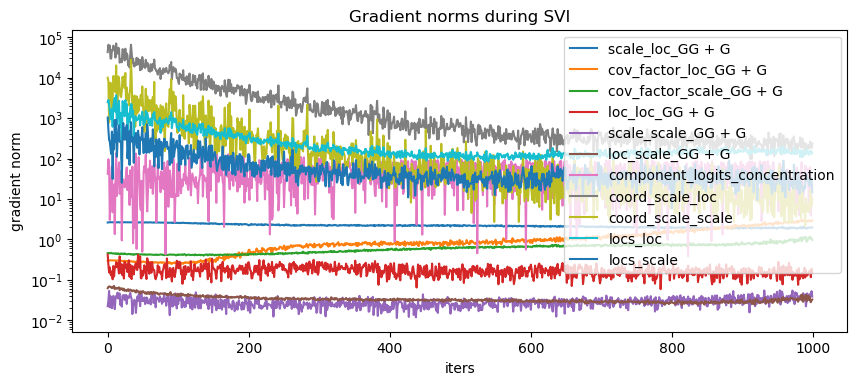

In [93]:
mg.plot_gradient_norms()

In [ ]:
mg.plot_posterior_predictive()

Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])


Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])


Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])
Guide locs shape is torch.Size([2, 10])
Model locs shape is torch.Size([2, 10])


In [ ]:
tmp = pyro.poutine.trace(foo_model).get_trace()

In [ ]:
tmp.log_prob_sum()

In [ ]:
?pyro.sample

In [ ]:
tmp = 

In [ ]:
tmp.dim

In [ ]:
type(dst.Normal(0,1))

In [ ]:
type(fa4.posterior_predictive(2))

In [ ]:
dst.Normal(0,1)

In [ ]:
pyro.sample('sdf', dst.Normal(0,1))

In [ ]:
pyro.sample('sdf', fa4.posterior_predictive, 2)

In [ ]:
dst.MixtureOfDiagNormalsSharedCovariance(locs=torch.zeros((4,3)), coord_scale=torch.ones(4), component_logits=torch.ones(4))